In [135]:
import numpy as np
from sympy import Matrix
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output

In [83]:
def excite_atoms(positions, states):
    for position in positions:
        states[position[0], position[1], position[2]] = 1
    return

def random_seeds_displacement(N_atoms_per_row, N_seeds):
    seeds_positions = np.random.choice(range(N_atoms_per_row**3), N_seeds, replace=False)
    z_positions = [seeds_positions[i]//(N_atoms_per_row**2) for i in range(N_seeds)]
    x_positions = [(seeds_positions[i]%(N_atoms_per_row**2))//N_atoms_per_row for i in range(N_seeds)]
    y_positions = [(seeds_positions[i]%(N_atoms_per_row**2))%N_atoms_per_row for i in range(N_seeds)]
    return x_positions, y_positions, z_positions
        
def get_neighbourhood(excited_atom, N_atoms_per_row):
    neighbours = [
                (excited_atom[0]-1, excited_atom[1], excited_atom[2]), 
                (excited_atom[0]+1, excited_atom[1], excited_atom[2]),
                (excited_atom[0], excited_atom[1]-1, excited_atom[2]), 
                (excited_atom[0], excited_atom[1]+1, excited_atom[2]),
                (excited_atom[0], excited_atom[1], excited_atom[2]-1), 
                (excited_atom[0], excited_atom[1], excited_atom[2]+1)
                ]
    for neighbour in neighbours.copy():
        if -1 in list(neighbour) or N_atoms_per_row in list(neighbour):
            neighbours.remove(neighbour)
    return neighbours

def unzip(list_of_touples):
    '''
    works only for 3D case.
    '''
    if len(list_of_touples) == 0:
        return [], [], []
    if list_of_touples is not list:
        list_of_touples = list(list_of_touples)
    aus_pos = np.zeros([len(list_of_touples[0]), len(list_of_touples)], dtype=int)
    for i in range(len(list_of_touples[0])):
        for j in range(len(list_of_touples)):
            aus_pos[i,j] = list_of_touples[j][i]
    return list(aus_pos[0,:]), list(aus_pos[1,:]), list(aus_pos[2,:])

In [84]:
a=random_seeds_displacement(4, 4)
print(a)
print(list(zip(a[0],a[1],a[2])))
len(list(zip(a[0],a[1],a[2])))
b = list(zip(a[0],a[1],a[2]))
list(zip(b[0],b[1],b[2],b[3]))

([2, 0, 0, 2], [2, 1, 0, 0], [0, 0, 1, 1])
[(2, 2, 0), (0, 1, 0), (0, 0, 1), (2, 0, 1)]


[(2, 0, 0, 2), (2, 1, 0, 0), (0, 0, 1, 1)]

First we excite the seed on resonance, exctracting the number of them from a Poissonian with mean "mu_exct_on_resonance".

Then the iteration of the facilitation process starts. 

In [97]:
def simulation( 
            mu_exct_on_resonance, # mean value of the poissonian to exctract the seeds.
            p_exct_OFF, # probability to excite an atom in the ground state close to a rydberg atom, in one step of the simulation.
            p_spontaneus_decay, # probability of spontaneous emission for an atom in one step.
            N_atoms_per_row, # shape of the MOT
            N_steps # number of steps.
            ):

    N_seeds = np.random.poisson(mu_exct_on_resonance) # extract from a poassonian the inital seeds
    x_excited, y_excited, z_excited = random_seeds_displacement(N_atoms_per_row=N_atoms_per_row, N_seeds=N_seeds) # extract the random positions of the seeds
    excited_atoms = list(zip(x_excited, y_excited, z_excited))

    for _ in range(N_steps):
        # first phase: check if the neighbours are already excited excite them with a certain probability.
        for excited_atom in excited_atoms.copy():
            neighbours = get_neighbourhood(excited_atom, N_atoms_per_row)
            for neighbour in neighbours:
                if neighbour not in excited_atoms and np.random.random()<p_exct_OFF:
                    excited_atoms.append(neighbour)
        # second phase: spontaneous decay of atoms.
        for excited_atom in excited_atoms.copy():
            if np.random.random()<p_spontaneus_decay:
                excited_atoms.remove(excited_atom)
    return excited_atoms

N atoms:  125000


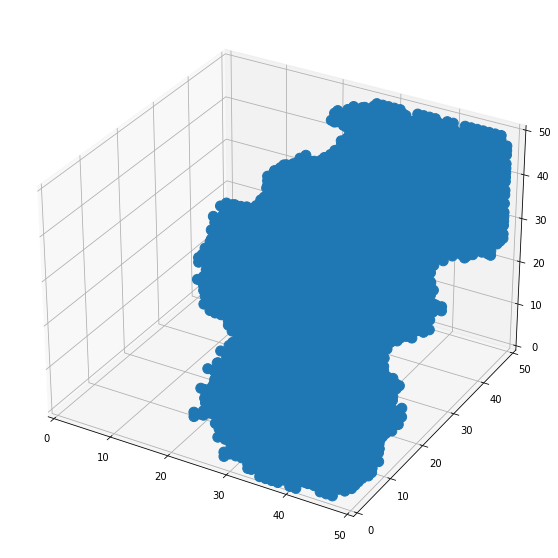

In [149]:
N_atoms_per_row = 50
print("N atoms: ", N_atoms_per_row*N_atoms_per_row*N_atoms_per_row)
mu_exct_on_resonance = 6
p_exct_OFF = 0.1
p_spontaneus_decay = 0.1
N_steps = 80

states = np.zeros([N_atoms_per_row, N_atoms_per_row, N_atoms_per_row])
excited_atoms = simulation(mu_exct_on_resonance, p_exct_OFF, p_spontaneus_decay, N_atoms_per_row, N_steps)
excite_atoms(excited_atoms, states)
final_pos = list(unzip(excited_atoms))
#print(final_pos)
x_pos, y_pos, z_pos = final_pos[0], final_pos[1], final_pos[2]
plt.figure(figsize=(13,10))
ax = plt.axes(projection ="3d")
ax.scatter3D(x_pos, y_pos, z_pos, marker="o", alpha=1, s=100)

ax.set_zlim(0,N_atoms_per_row)
ax.set_xlim(0,N_atoms_per_row)
ax.set_ylim(0,N_atoms_per_row)
plt.show()

In [132]:
N_points = 20
N_exp_per_point = 6
N_atoms_per_row = 50
mu_exct_on_resonance = 2
p_spontaneus_decay = 0.5
N_steps = 20
fac_probs = np.linspace(0,1, N_points)
N_final_atoms = np.zeros(N_points)
std_final_atoms = np.zeros(N_points)

for i, p_exct_OFF in enumerate(fac_probs):
    clear_output(wait=True)
    print(i/N_points*100, "%")
    ausiliar_array = np.zeros(N_exp_per_point)
    for j in range(N_exp_per_point):
        ausiliar_array[j] = len(simulation(mu_exct_on_resonance, p_exct_OFF, p_spontaneus_decay, N_atoms_per_row, N_steps))
    N_final_atoms[i] = np.mean(ausiliar_array)
    std_final_atoms[i] = np.std(ausiliar_array)

95.0 %


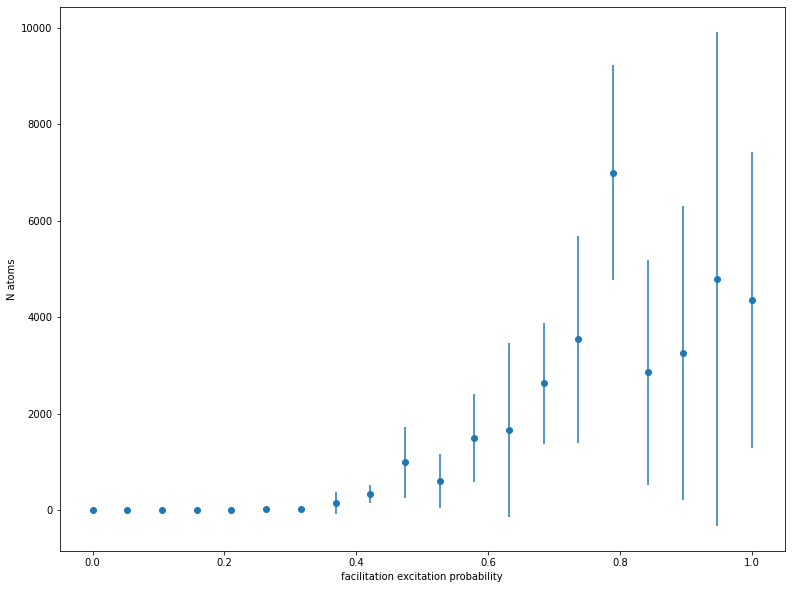

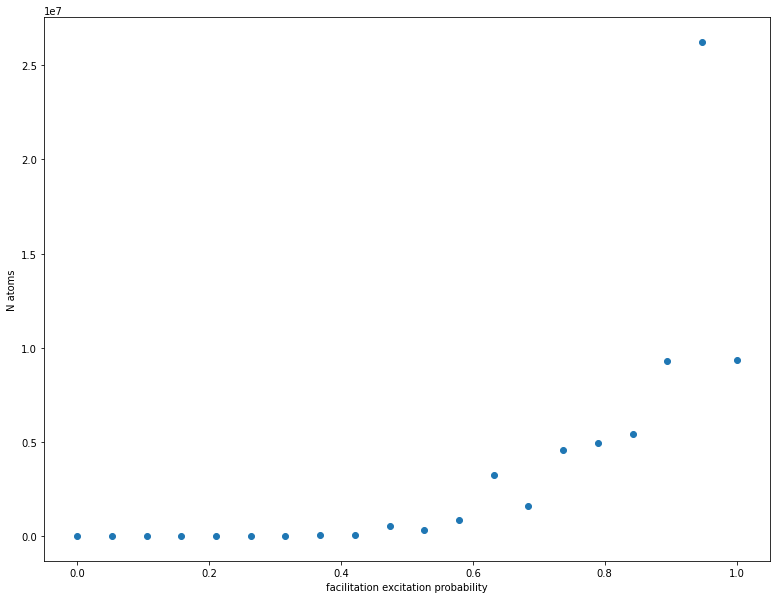

In [133]:
plt.figure(figsize=(13,10))
plt.errorbar(fac_probs, N_final_atoms, std_final_atoms, linestyle="", marker="o")
plt.xlabel("facilitation excitation probability")
plt.ylabel("N atoms")
plt.show()

plt.figure(figsize=(13,10))
plt.plot(fac_probs, std_final_atoms**2, linestyle="", marker="o")
plt.xlabel("facilitation excitation probability")
plt.ylabel("N atoms")
plt.show()

# Histogram of one simulation

99.8 %


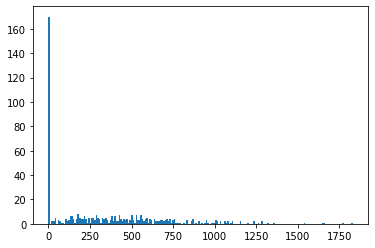

In [156]:
N_points = 500
N_atoms_per_row = 50
mu_exct_on_resonance = 2
p_spontaneus_decay = 0.5
N_steps = 40
p_exct_OFF = 0.3

ausiliar_array = np.zeros(N_points)
for j in range(N_points):
    clear_output(wait=True)
    print(j/N_points*100, "%")
    ausiliar_array[j] = len(simulation(mu_exct_on_resonance, p_exct_OFF, p_spontaneus_decay, N_atoms_per_row, N_steps))

mean = np.mean(ausiliar_array)
std = np.std(ausiliar_array)

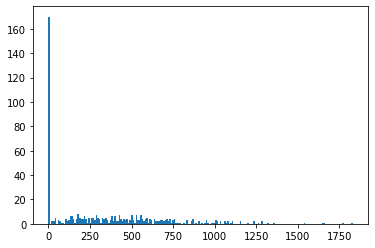

In [160]:
plt.hist((ausiliar_array), bins=np.linspace(0,max(ausiliar_array), 200))
plt.show()

# Animated simulation

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


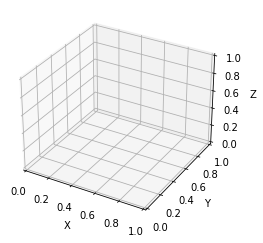

In [150]:
np.random.seed(19680801)

def random_walk(num_steps, max_step=0.05):
    """Return a 3D random walk as (num_steps, 3) array."""
    start_pos = np.random.random(3)
    steps = np.random.uniform(-max_step, max_step, size=(num_steps, 3))
    walk = start_pos + np.cumsum(steps, axis=0)
    return walk


def update_lines(num, walks, lines):
    for line, walk in zip(lines, walks):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(walk[:num, :2].T)
        line.set_3d_properties(walk[:num, 2])
    return lines


# Data: 40 random walks as (num_steps, 3) arrays
num_steps = 30
walks = [random_walk(num_steps) for index in range(40)]

# Attaching 3D axis to the figure
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Create lines initially without data
lines = [ax.plot([], [], [])[0] for _ in walks]

# Setting the axes properties
ax.set(xlim3d=(0, 1), xlabel='X')
ax.set(ylim3d=(0, 1), ylabel='Y')
ax.set(zlim3d=(0, 1), zlabel='Z')

# Creating the Animation object
ani = animation.FuncAnimation(fig, update_lines, num_steps, fargs=(walks, lines), interval=100)

plt.show()